In [1]:
import numpy as np

import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
import prediction_regression_pipeline as prp
from importlib import reload



In [2]:
!echo $(hostname) $(git rev-parse --short HEAD)

tycho eb322be



## Prediction tables


In [3]:
%%time
runs = []

to_try = np.linspace(0, 0.25, 1)
for x in to_try:
    run = prp.PipelineRun(
        neural_lag=x, dataset='zong22', exit_time=-1, 
        pos_scale=1, hd_scale=1, h2b_scale=1
    )
    runs.append(run)



  0%|          | 0/579.9333333333333 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/mmica/_densities.py", line 44:
@jit(parallel=True, fastmath=True, nopython=True)
def logp_u(Y):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


CPU times: user 6min 20s, sys: 1min 1s, total: 7min 21s
Wall time: 9min 1s


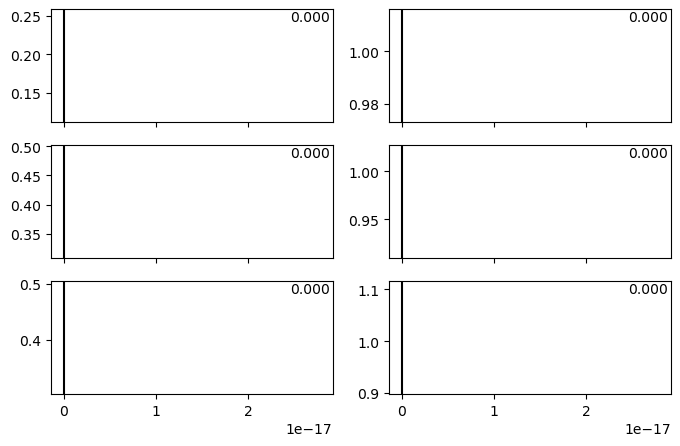

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, figsize=(4*2,5), sharex=True)
for idx, target_str in enumerate(['beh', 'neural', 'joint']):
    correlations = np.array([getattr(run, f'{target_str}_correlations') for run in runs])
    mses = np.array([getattr(run, f'{target_str}_nrmses') for run in runs])
    for jdx, metric in enumerate([correlations, mses]):
        axs[idx,jdx].plot(to_try, metric)
        metric = -metric if jdx == 1 else metric
        best_tried = to_try[np.argmax(metric.sum(axis=1))]
        axs[idx, jdx].axvline(best_tried, color='k')
        axs[idx, jdx].text(.99, .99, f'{best_tried:.3f}', ha='right', va='top', transform=axs[idx, jdx].transAxes)


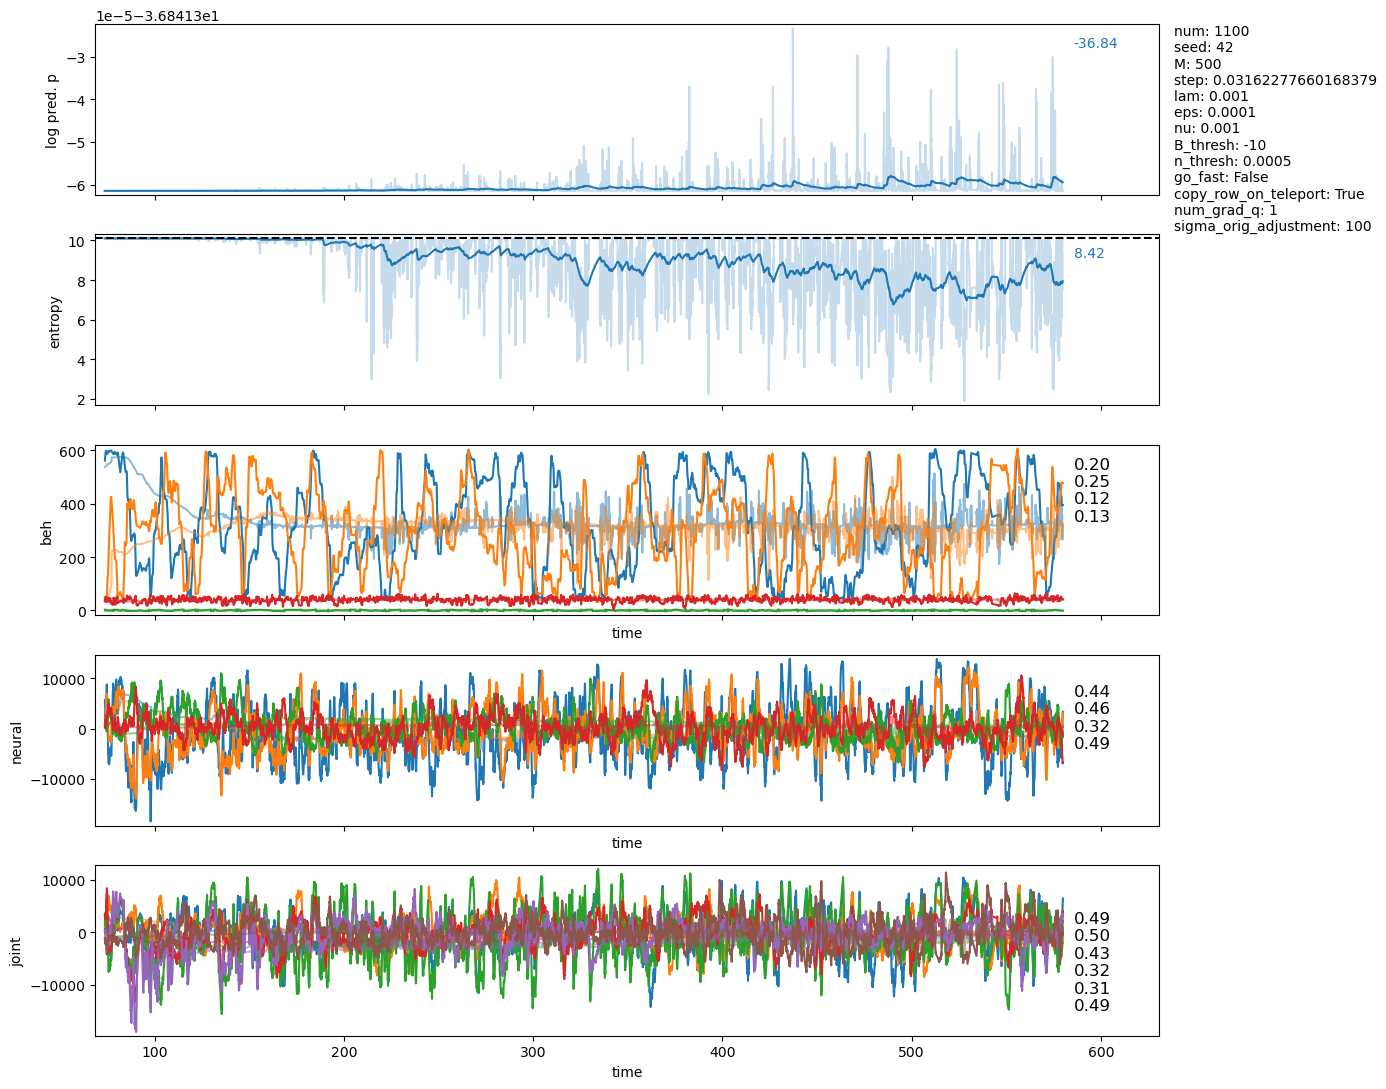

In [10]:
%matplotlib inline
runs[-1].plot_results()

# plt.gcf().axes[-2].set_xlim([550, 600])


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.30850609, 1.40850609, 1.50850609, 1.60850609, 1.70850609,
        1.80850609, 1.90850609, 2.00850609, 2.10850609, 2.20850609,
        2.30850609]),
 <BarContainer object of 10 artists>)

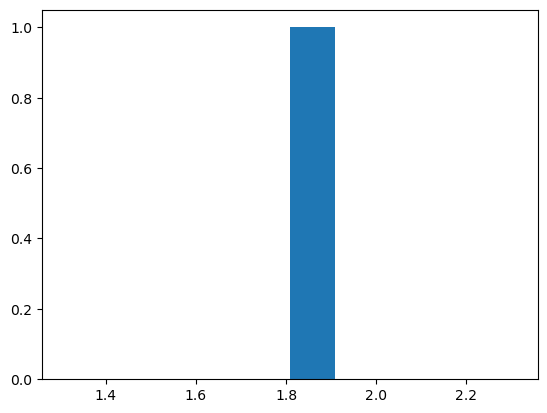

In [35]:
plt.hist(np.nanstd(run.d.behavioral_data.a[:,:,2], axis=0).flatten()) # 1200

Text(0, 0.5, 'ica')

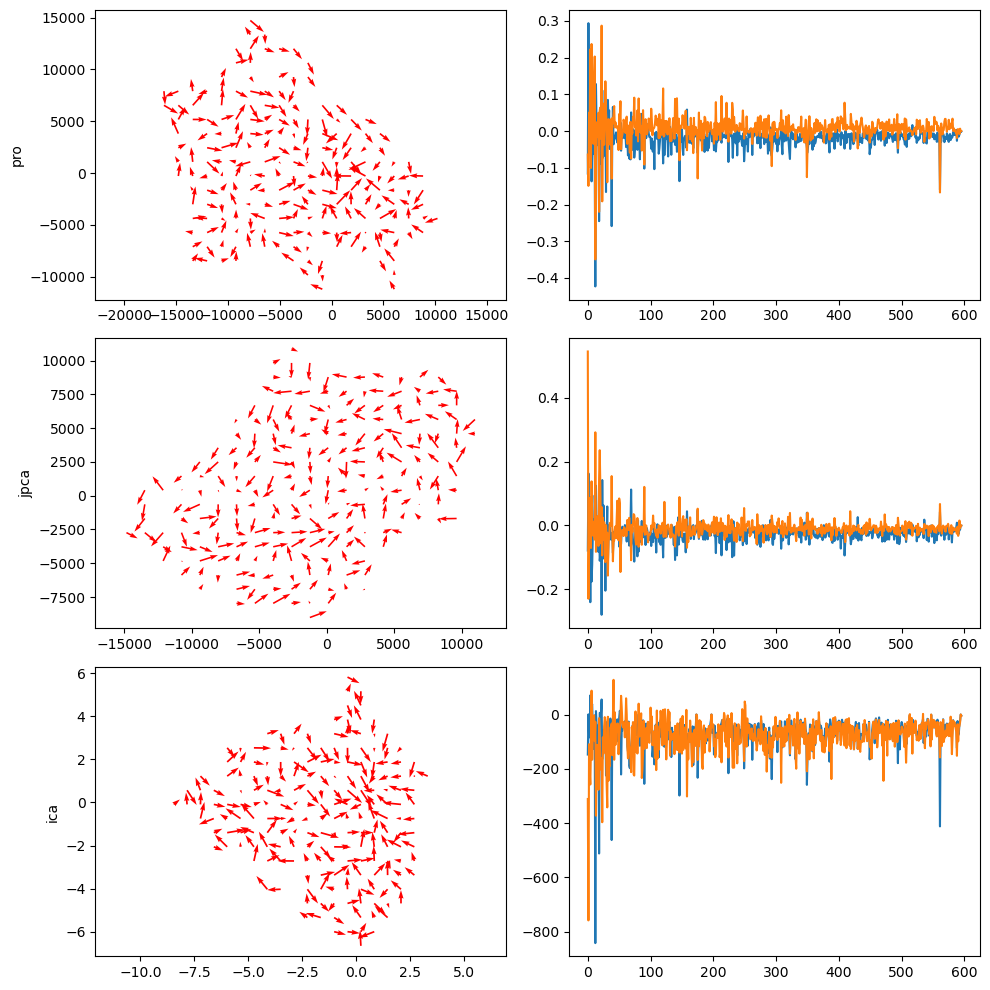

In [6]:
%matplotlib inline
 
fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, layout='tight', figsize=(10, 10))
e1, e2 = np.zeros(6), np.zeros(6)
e1[0] = 1
e2[1] = 1

for idx, latents in enumerate([run.pro_latents, run.jpca_latents, run.ica_latents]):
    ax: plt.Axes = axs[idx, 0]
    # ax.scatter(latents[:,0], latents[:,1], s=5)

    d_latents = np.diff(latents, axis=0)
    d_latents = d_latents / np.linalg.norm(d_latents, axis=1)[:, np.newaxis]
    ax.quiver(latents[:-1] @ e1, latents[:-1]@e2, d_latents@e1, d_latents@e2, scale=1 / 20, units='dots', alpha=0)
    x1, x2, y1, y2 = ax.axis()
    x_points = np.linspace(x1, x2, 21)
    y_points = np.linspace(y1, y2, 21)
    # mgrid = np.meshgrid(*[np.linspace(latents[:, i].min(), latents[:, i].max(), 10) for i in range(2)])
    origins = []
    arrows = []
    for i in range(len(x_points) - 1):
        for j in range(len(y_points) - 1):
            proj_1 = (latents[:-1] @ e1)
            proj_2 = (latents[:-1] @ e2)
            s = (x_points[i] <= proj_1) & (proj_1 < x_points[i + 1]) & (y_points[j] <= proj_2) & (
                    proj_2 < y_points[j + 1])
            if s.sum():
                arrow = d_latents[s].mean(axis=0)
                arrow = arrow / np.linalg.norm(arrow)
                arrows.append(arrow)
                origins.append([x_points[i:i + 2].mean(), y_points[j:j + 2].mean()])
    origins, arrows = np.array(origins), np.array(arrows)
    ax.quiver(origins[:, 0], origins[:, 1], arrows @ e1, arrows @ e2, scale=1 / 20, units='dots', color='red')

    ax.axis('equal')

axs[0, 1].plot(run.pro.inverse_transform(e1, 2))
axs[0, 1].plot(run.pro.inverse_transform(e2, 2))
axs[0, 0].set_ylabel('pro')

axs[1, 1].plot(run.pro.inverse_transform(run.jpca.inverse_transform(e1, 2), 2))
axs[1, 1].plot(run.pro.inverse_transform(run.jpca.inverse_transform(e2, 2), 2))
axs[1, 0].set_ylabel('jpca')

axs[2, 1].plot(run.pro.inverse_transform(run.ica.inverse_transform(e1, 2), 2))
axs[2, 1].plot(run.pro.inverse_transform(run.ica.inverse_transform(e2, 2), 2))
axs[2, 0].set_ylabel('ica')

6


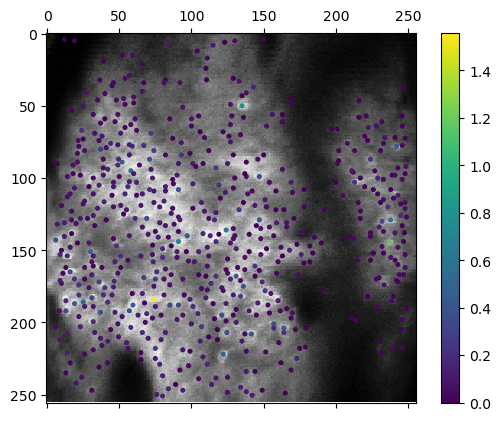

In [7]:
if isinstance(run.d, datasets.Zong22Dataset):
    desired_pattern = np.mean(latents[-101:-1], axis=0)
    current_pattern = latents[-1]
    desired_stim = desired_pattern - current_pattern
    
    desired_pattern = (desired_stim @ run.pro.Q.T)[:run.d.neural_data.a.shape[-1]]
    
    near_zero = np.abs(desired_stim) < 100
    print(near_zero.sum())
    desired_stim[near_zero] = np.nan
    
    
    fig, ax = plt.subplots()
    run.d.show_stim_pattern(ax, np.abs(desired_pattern))


NameError: name 'jpca_latents' is not defined

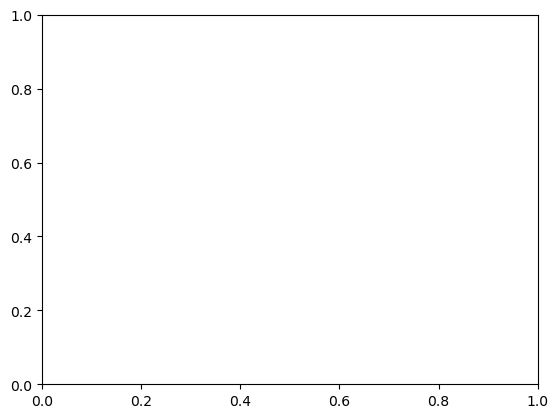

In [8]:
fig, ax = plt.subplots()

latents = jpca_latents

dim_1, dim_2 = 0,1
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)

ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')

ax.axis('equal');



## Intro video

In [ ]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()